In [91]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim import AdamW
import matplotlib.pyplot as plt
import random

from tokenizers import models, pre_tokenizers
from tokenizers.normalizers import Sequence, NFD, StripAccents
from tokenizers.trainers import BpeTrainer
from tokenizers.decoders import ByteLevel, Metaspace
from tokenizers.processors import TemplateProcessing
from tokenizers import Tokenizer

import pandas as pd

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

from bertviz import head_view
from IPython.display import display

## Some easy accessible values used everywhere

In [110]:
batch_size = 4
block_size = 128
embedding_dim = 128

## Custom tokenizer

In [103]:
# https://figshare.com/articles/dataset/Code_Snippets_Dataset/22623331?file=40146943
df = pd.read_csv("../datasets/code_snippets.csv")
code_snippets = df["code"].tolist()

* tokenizer is trained via Huggingface tokenizers library
* I wanted to keep readable words, later then used in attention visualization, so metaspace pretokenizer is used
* Padding for the shorter sequences of code snippets and added [CLS] token as first token 

In [167]:
tokenizer = Tokenizer(models.BPE(unk_token="[UNK]"))
tokenizer.normalizer = Sequence([NFD(), StripAccents()])
tokenizer.pre_tokenizer = pre_tokenizers.Metaspace()  

special_tokens = ["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]"]
trainer = BpeTrainer(vocab_size=2048, special_tokens=special_tokens)
tokenizer.train_from_iterator(code_snippets, trainer=trainer)
tokenizer.decoder = Metaspace()
tokenizer.post_processor = TemplateProcessing(
    single="[CLS] $A [SEP]",
    special_tokens=[
        ("[CLS]", 2), ("[SEP]", 3)
    ]
)
tokenizer.enable_padding(
    direction='right',
    pad_token='[PAD]',
    pad_id=0,
    length=block_size
)

tokenizer.enable_truncation(
    max_length=block_size
)

tokenizer.save("code_tokenizer_metaspace.json")

In [166]:
# checks if it encodes and decodes in the same exact way -> later used in attention visualization

ids = tokenizer.encode("predicted_label = dataset.labels[predictions[0].item()]\n\nprint(Hello)").ids
print(tokenizer.decode(ids))

predicted_label = dataset.labels[predictions[0].item()]

print(Hello)


## Dataset definition

In [168]:
class MyDataset(Dataset):
    def __init__(self, df, tokenizer, max_length = block_size):
        self.data = df
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.labels = sorted(self.data['language'].unique())
        self.label2id = {lang: idx for idx, lang in enumerate(self.labels)}
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        code = self.data.iloc[idx]['code']
        label = self.label2id[self.data.iloc[idx]["language"]]
        
        encoding = self.tokenizer.encode(code)
        
        return {
            'input_ids': torch.tensor(encoding.ids, dtype=torch.long),
            'attention_mask': torch.tensor(encoding.attention_mask, dtype=torch.long),
            'label': torch.tensor(label, dtype=torch.long),
        }

In [169]:
dataset = MyDataset(df, tokenizer)

# classic train/val split. No test split
train_dataset, val_dataset = random_split(dataset, [0.85, 0.15])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [170]:
# checking if all labels are in both dataset splits (just making sure)
def get_labels_from_subset(subset):
    labels = []
    for i in range(len(subset)):
        item = subset[i]  
        labels.append(item['label'].item()) 
    return labels

train_labels = get_labels_from_subset(train_dataset)
val_labels = get_labels_from_subset(val_dataset)

print("Train classes:", set(train_labels))
print("Validation classes:", set(val_labels))

Train classes: {0, 1, 2, 3, 4, 5, 6, 7, 8}
Validation classes: {0, 1, 2, 3, 4, 5, 6, 7, 8}


In [171]:
next(iter(train_loader))

{'input_ids': tensor([[   2,  935, 1571,   57,  868,   86,  896, 1654,   53,   58,  751,  717,
           280, 1020,  988, 1199,   51,   80,  686, 1881,   35,  711, 1006,   90,
           767,   74, 1236,  876,   90,  767,   74, 1236, 1062,  879,  701, 2043,
          1006,  848,  974,  876,   48,  748,   84,  879,  766, 2043,   37,  701,
          2043, 1006,  682, 1872,  702,  876,  682, 1872, 1074,  766, 2043, 1300,
           711,   37, 1563,   11,  869,   10, 1163,   32,  959,  992,  767,   74,
          1236, 1723,  280,  280, 1054,  980,  869, 2043, 1518,  974, 1723, 1125,
           743,   73,  980,  869,   74, 1396, 1518,  697, 1723, 1125,   73,  980,
           869,   74, 1396, 1518,  697,  931, 1718,  717,  280,  280,  988, 1674,
            16,  835, 1495,  751, 1225,  927, 1483,   11, 1199,   51,   80,  692,
           280,  280, 1571,   57,  868,   86,  896,    3],
         [   2, 1168, 1098, 1392, 1249, 1065,  280, 1168, 1006, 1024, 1469, 1753,
          1065,  280,  280

## Evaluation and training loop

* Evaluating on whole validation split
* Can display confusion matrix on validation split

* Classic training loop with logging of important statistics, norm clipping and validation testing

In [2]:
import time

device = "cuda" if torch.cuda.is_available() else "cpu"

@torch.no_grad()
def evaluate(model, val_loader, max_batches=None, show_confusion_matrix=False, class_names=None):
    model.eval()
    total_loss = 0
    correct = total = 0
    
    all_preds = []
    all_labels = []
    
    for i, batch in enumerate(val_loader):
        # limit out to specific number of batches 
        if max_batches is not None and i >= max_batches:
            break
        
        # get current batch ids, attention masks and labels
        input_ids = batch['input_ids'].to(device)
        attn_masks = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        
        # predict and calculate loss
        logits = model(input_ids, attn_masks, return_attention=False)
        loss = F.cross_entropy(logits, labels)
        total_loss += loss.item()
        
        # could be calculated right away from the logits
        probs = torch.softmax(logits, dim=1)
        preds = torch.argmax(probs, dim=1)
        
        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(labels.cpu().tolist())
        
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    if show_confusion_matrix:
        cm = confusion_matrix(all_labels, all_preds)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
        fig, ax = plt.subplots(figsize=(8, 6))
        disp.plot(ax=ax, xticks_rotation=45, cmap='Blues')
        plt.title("Confusion Matrix")
        plt.tight_layout()
        plt.show()
    
    avg_loss = total_loss / (max_batches if max_batches else len(val_loader))
    avg_acc = correct / total
    return avg_loss, avg_acc     

def train(model, train_loader, val_loader, optimizer, epochs=3, val_every=100, val_batches=None, norm_clipping=False):
    model.to(device)
    model.train()
    step = 0
    
    # some stats to log
    train_losses = []
    grad_norms = []
    val_losses = []
    val_accuracies = []
    tokens_per_sec_arr = []
    tokens_processed = 0
    start_time = time.time()
    
    for epoch in range(epochs):
        for batch in train_loader:
            # get current batch ids, attention masks and labels
            input_ids = batch["input_ids"].to(device)
            attn_masks = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            # calculate logits and loss
            logits = model(input_ids, attn_masks, return_attention=False)
            loss = F.cross_entropy(logits, labels)

            optimizer.zero_grad()
            loss.backward()
            
            # clip grad norms (helps with training)
            if norm_clipping:
                total_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            else:
                total_norm = 0.0
                for p in model.parameters():
                    if p.grad is not None:
                        param_norm = p.grad.data.norm(2)
                        total_norm += param_norm.item() ** 2
                total_norm = total_norm ** 0.5
            
            optimizer.step()

            tokens_processed += input_ids.numel()
            
            # calculate loss, accuracy on validation split and log stats 
            if step % val_every == 0:
                elapsed = time.time() - start_time
                tokens_per_sec = tokens_processed / elapsed
                tokens_per_sec_arr.append(tokens_per_sec)
                val_loss, val_acc = evaluate(model, val_loader, max_batches=val_batches)
                train_losses.append(loss.item()), grad_norms.append(total_norm.item()), val_losses.append(val_loss), val_accuracies.append(val_acc)
                print(f"[Step {step}] Train loss: {loss:.4f} | Grad norm: {total_norm:.4f} | Validation Loss: {val_loss:.4f} | Accuracy on {val_batches if val_batches else "all"} val batches: {val_acc:.2%} | Throughput: {tokens_per_sec:.2f} tokens/sec")
            
                tokens_processed = 0
                start_time = time.time()
                
            step += 1
    
    return train_losses, grad_norms, val_losses, val_accuracies, tokens_per_sec_arr    

NameError: name 'torch' is not defined

# Models


* Prediction is based on [CLS] token taken in the last layer by the classifier (another possible solution is to average/sum out all other vectors to get 1 vector that is passed into the last layer)
* Gradually increasing model complexity to see to accuracy increase 

## Basic Model

* super simple embedding and linear layer neural network

In [174]:
class TransformerClassifierV1(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_classes):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.classifier = nn.Linear(embedding_dim, num_classes)
        
    def forward(self, x, *args, **kwargs):
        embedded = self.embedding(x)
        cls_token = embedded[:, 0, :]
        
        logits = self.classifier(cls_token)
        return logits # (batch_size, num_classes)
            

In [175]:
vocab_size = tokenizer.get_vocab_size()
num_classes = len(dataset.labels)

In [176]:
model_v1 = TransformerClassifierV1(vocab_size, embedding_dim, num_classes)
optimizer = AdamW(model_v1.parameters(), lr=1e-3)
stats_v1 = train(model_v1, train_loader, val_loader, optimizer, epochs=5, val_every=500, val_batches=None, norm_clipping=True)

[Step 0] Train loss: 2.5223 | Grad norm: 4.8465 | Validation Loss: 2.3183 | Accuracy on all val batches: 10.64% | Throughput: 111598.17 tokens/sec
[Step 500] Train loss: 2.3194 | Grad norm: 4.5608 | Validation Loss: 2.2310 | Accuracy on all val batches: 10.30% | Throughput: 101756.12 tokens/sec
[Step 1000] Train loss: 2.3971 | Grad norm: 7.3165 | Validation Loss: 2.2378 | Accuracy on all val batches: 11.73% | Throughput: 103412.18 tokens/sec
[Step 1500] Train loss: 2.1470 | Grad norm: 4.0034 | Validation Loss: 2.2477 | Accuracy on all val batches: 10.64% | Throughput: 110818.45 tokens/sec
[Step 2000] Train loss: 2.1623 | Grad norm: 3.9188 | Validation Loss: 2.2090 | Accuracy on all val batches: 11.14% | Throughput: 104320.87 tokens/sec
[Step 2500] Train loss: 2.0611 | Grad norm: 6.3385 | Validation Loss: 2.2051 | Accuracy on all val batches: 11.56% | Throughput: 103796.23 tokens/sec
[Step 3000] Train loss: 2.4101 | Grad norm: 4.4801 | Validation Loss: 2.2372 | Accuracy on all val batch

## Model with position embeddings

* added positional embedding for sentences

In [179]:
class TransformerClassifierV2(nn.Module):
    def __init__(self, vocab_size, n_embd, num_classes, block_size):
        super().__init__()
        self.token_embedding = nn.Embedding(vocab_size, n_embd)
        self.position_embedding = nn.Embedding(block_size, n_embd)
        self.classifier = nn.Linear(n_embd, num_classes)

    def forward(self, x, *args, **kwargs):
        B, T = x.shape
        
        tok_emb = self.token_embedding(x)
        pos_emb = self.position_embedding(torch.arange(T, device=x.device))  
        out = tok_emb + pos_emb 
        cls_token = out[:, 0, :]
        logits = self.classifier(cls_token)
        return logits

In [180]:
model_v2 = TransformerClassifierV2(vocab_size, embedding_dim, num_classes, block_size)
optimizer = AdamW(model_v2.parameters(), lr=1e-3)
stats_v2 = train(model_v2, train_loader, val_loader, optimizer, epochs=5, val_every=500, val_batches=None, norm_clipping=True)

[Step 0] Train loss: 3.2568 | Grad norm: 12.0665 | Validation Loss: 2.5756 | Accuracy on all val batches: 11.14% | Throughput: 53349.65 tokens/sec
[Step 500] Train loss: 2.3817 | Grad norm: 6.0040 | Validation Loss: 2.2402 | Accuracy on all val batches: 11.73% | Throughput: 95504.58 tokens/sec
[Step 1000] Train loss: 2.3363 | Grad norm: 5.9709 | Validation Loss: 2.2505 | Accuracy on all val batches: 11.14% | Throughput: 103832.93 tokens/sec
[Step 1500] Train loss: 2.1401 | Grad norm: 4.9701 | Validation Loss: 2.2411 | Accuracy on all val batches: 11.14% | Throughput: 102896.07 tokens/sec
[Step 2000] Train loss: 2.0837 | Grad norm: 6.6525 | Validation Loss: 2.2262 | Accuracy on all val batches: 10.72% | Throughput: 99969.58 tokens/sec
[Step 2500] Train loss: 2.0097 | Grad norm: 6.1310 | Validation Loss: 2.2353 | Accuracy on all val batches: 12.48% | Throughput: 94641.21 tokens/sec
[Step 3000] Train loss: 2.1423 | Grad norm: 4.5281 | Validation Loss: 2.2104 | Accuracy on all val batches:

## One self attention head without casual mask

* No casual mask, because we can look at the whole sentence, since we are not generating token by token, but predicting a label

In [181]:
class Head(nn.Module):
    def __init__(self, head_size, embedding_dim, dropout, block_size):
        super().__init__()
        self.key = nn.Linear(embedding_dim, head_size, bias=False)
        self.query = nn.Linear(embedding_dim, head_size, bias=False)
        self.value = nn.Linear(embedding_dim, head_size, bias=False)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, attention_mask=None, return_attention=False):
        B, T, C = x.shape 
        
        k = self.key(x) # (B, T, head_size)
        q = self.query(x) # (B, T, head_size)
        v = self.value(x) # (B, T, head_size)
        
        wei = q @ k.transpose(-2, -1) * k.shape[-1]**-0.5 # (B, T, head_size) * (B, head_size, T) -> (B, T, T)
        
        # mask out [PAD] tokens
        if attention_mask is not None:
            mask = attention_mask[:, None, :]
            wei = wei.masked_fill(mask == 0, float('-inf'))
        
        wei_soft = F.softmax(wei, dim=-1) # keep attention so it can be later visualized
        wei_drop = self.dropout(wei_soft)
        
        out = wei_drop @ v # (B, T, T) * (B, T, head_size) -> (B, T, head_size) 
        return (out, wei_soft) if return_attention else out
        
           

In [182]:
class TransformerClassifierV3(nn.Module):
    def __init__(self, vocab_size, n_embd, num_classes, block_size, dropout=0.2):
        super().__init__()
        self.token_embedding = nn.Embedding(vocab_size, n_embd)
        self.position_embedding = nn.Embedding(block_size, n_embd)
        self.attn_head = Head(n_embd, n_embd, dropout, block_size)
        self.classifier = nn.Linear(n_embd, num_classes)

    def forward(self, x, attn_masks=None, return_attention=False):
        B, T = x.shape
        tok_emb = self.token_embedding(x)
        pos_emb = self.position_embedding(torch.arange(T, device=x.device))
        
        out = tok_emb + pos_emb  # (B, T, C)
        
        if return_attention:
            out, attention = self.attn_head(out, attn_masks, return_attention=True)  # (B, T, C)
        else:
            out = self.attn_head(out, attn_masks)
            attention = None
                
        cls_token = out[:, 0, :]
        logits = self.classifier(cls_token)
        return (logits, attention) if return_attention else logits

In [183]:
model_v3 = TransformerClassifierV3(vocab_size, embedding_dim, num_classes, block_size)
optimizer = AdamW(model_v3.parameters(), lr=1e-3)
stats_v3 = train(model_v3, train_loader, val_loader, optimizer, epochs=5, val_every=500, val_batches=None, norm_clipping=True)

[Step 0] Train loss: 2.3220 | Grad norm: 1.7849 | Validation Loss: 2.1994 | Accuracy on all val batches: 11.98% | Throughput: 68275.96 tokens/sec
[Step 500] Train loss: 0.8625 | Grad norm: 6.1328 | Validation Loss: 1.5750 | Accuracy on all val batches: 46.15% | Throughput: 64999.76 tokens/sec
[Step 1000] Train loss: 1.6156 | Grad norm: 5.5345 | Validation Loss: 1.2039 | Accuracy on all val batches: 62.40% | Throughput: 63217.18 tokens/sec
[Step 1500] Train loss: 0.0609 | Grad norm: 0.7501 | Validation Loss: 0.9757 | Accuracy on all val batches: 70.10% | Throughput: 67478.18 tokens/sec
[Step 2000] Train loss: 0.0308 | Grad norm: 0.3744 | Validation Loss: 1.0390 | Accuracy on all val batches: 69.60% | Throughput: 63619.30 tokens/sec
[Step 2500] Train loss: 0.9987 | Grad norm: 6.9420 | Validation Loss: 0.6243 | Accuracy on all val batches: 82.66% | Throughput: 70093.89 tokens/sec
[Step 3000] Train loss: 0.9223 | Grad norm: 2.6695 | Validation Loss: 0.6224 | Accuracy on all val batches: 82

In [184]:
torch.save({
    'model_state_dict': model_v3.state_dict(),
    'batch_size': 4,
    'block_size': 128,
    'embedding_dim': 128,
    'vocab_size': tokenizer.get_vocab_size(),
    'num_classes': len(dataset.labels)
}, 'model_v3.pt')

## Visualize attention using Bertviz

In [185]:
model_v3.eval()
with torch.no_grad():
    batch = next(iter(val_loader))
    input_ids = batch["input_ids"].to(device)
    labels = batch['label'].to(device)
    attention_mask = batch["attention_mask"].to(device)
    logits, attention = model_v3(input_ids, attention_mask, return_attention=True)
    prediction = logits.argmax(dim=-1)[0].item()
    
    first_input_ids = input_ids[0]
    tokens = []
    for id in first_input_ids:
        token = tokenizer.id_to_token(id)
        if token != '[CLS]' and token != '[PAD]':
            tokens.append(token)
    
    raw_text = tokenizer.decode(first_input_ids.tolist(), skip_special_tokens=True)
    current_language = dataset.labels[labels[0].item()]
    print(f"Raw input text of {current_language} with prediction {dataset.labels[prediction]}:\n")
    print(raw_text)
    
    attention_matrix = attention[0].cpu() # (T, T)
    N = 30
    tokens = tokens[:N]
    attention_matrix = attention_matrix[:N, :N].unsqueeze(0).unsqueeze(0)  # shape: (1, 1, N, N)
    
    display(head_view(attention=[attention_matrix], tokens=tokens, sentence_b_start=None))

Raw input text of c with prediction c:

do {
        printf("Word length... ");
        scanf("%d", &wdlen);
    } while(wdlen<2);

while(wdlen<2){
        printf("Word length... ");
        scanf("%d", &wdlen);
    } 




<IPython.core.display.Javascript object>

None

## Multihead attention


In [186]:
class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, head_size, embedding_dim, dropout=0.0):
        super().__init__()
        self.heads = nn.ModuleList(
            [Head(head_size, embedding_dim, dropout, block_size) for _ in range(num_heads)]
        )
        self.proj = nn.Linear(num_heads * head_size, embedding_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, attn_masks=None):
        out = torch.cat([h(x, attn_masks) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out    

In [187]:
class TransformerClassifierV4(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_classes, block_size, n_heads, dropout=0.0):
        super().__init__()
        self.token_embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.positional_embeddings = nn.Embedding(block_size, embedding_dim)
        head_size = embedding_dim // n_heads
        self.sa_heads = MultiHeadAttention(n_heads, head_size, embedding_dim, dropout)
        self.classifier = nn.Linear(embedding_dim, num_classes)
    
    def forward(self, x, attn_masks=None, *args, **kwargs):
        B, T = x.shape
        
        token_emb = self.token_embeddings(x)
        pos_emb = self.positional_embeddings(torch.arange(T, device=x.device))
        
        out = token_emb + pos_emb
        out = self.sa_heads(out, attn_masks)
        cls_token = out[:, 0, :]
        logits = self.classifier(cls_token)
        return logits

In [188]:
n_heads = 4
model_v4 = TransformerClassifierV4(vocab_size, embedding_dim, num_classes, block_size, n_heads=4, dropout=0.2)
optimizer = AdamW(model_v4.parameters(), lr=1e-3)

stats_v4 = train(model_v4, train_loader, val_loader, optimizer, epochs=5, val_every=500, val_batches=None, norm_clipping=True)

[Step 0] Train loss: 2.1946 | Grad norm: 1.3357 | Validation Loss: 2.1964 | Accuracy on all val batches: 11.73% | Throughput: 15349.04 tokens/sec
[Step 500] Train loss: 0.6493 | Grad norm: 6.6183 | Validation Loss: 1.1105 | Accuracy on all val batches: 62.06% | Throughput: 47767.23 tokens/sec
[Step 1000] Train loss: 1.3000 | Grad norm: 41.5835 | Validation Loss: 0.8600 | Accuracy on all val batches: 73.70% | Throughput: 45765.86 tokens/sec
[Step 1500] Train loss: 0.0132 | Grad norm: 0.3676 | Validation Loss: 0.7295 | Accuracy on all val batches: 77.30% | Throughput: 42527.24 tokens/sec
[Step 2000] Train loss: 2.2738 | Grad norm: 18.2717 | Validation Loss: 0.6674 | Accuracy on all val batches: 79.82% | Throughput: 42443.81 tokens/sec
[Step 2500] Train loss: 0.0590 | Grad norm: 3.1934 | Validation Loss: 0.7218 | Accuracy on all val batches: 80.57% | Throughput: 42967.77 tokens/sec
[Step 3000] Train loss: 0.0156 | Grad norm: 0.4575 | Validation Loss: 0.6989 | Accuracy on all val batches: 

## Full transformer model (Multihead attention, layers norms, feedforward)

In [189]:
class FeedFoward(nn.Module):
    def __init__(self, n_embd, dropout):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    def __init__(self, n_embd, n_head, dropout):
        super().__init__()
        head_size = n_embd // n_head
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)
        self.sa = MultiHeadAttention(n_head, head_size, n_embd, dropout)
        self.ffwd = FeedFoward(n_embd, dropout)

    def forward(self, x, attn_masks=None):
        x = x + self.sa(self.ln1(x), attn_masks)
        x = x + self.ffwd(self.ln2(x))
        return x

In [190]:
class TransformerClassifierV5(nn.Module):
    def __init__(self, vocab_size, n_embd, num_classes, block_size, n_layer, n_head, dropout=0.1):
        super().__init__()
        self.token_embedding = nn.Embedding(vocab_size, n_embd)
        self.position_embedding = nn.Embedding(block_size, n_embd)
        self.blocks = nn.ModuleList([Block(n_embd, n_head, dropout) for _ in range(n_layer)])
        self.norm = nn.LayerNorm(n_embd)
        self.classifier = nn.Linear(n_embd, num_classes)

    def forward(self, x, attn_mask=None, *args, **kwargs):
        B, T = x.shape
        tok_emb = self.token_embedding(x)
        pos_emb = self.position_embedding(torch.arange(T, device=x.device))
        out = tok_emb + pos_emb
        
        for block in self.blocks:
            out = block(out, attn_mask)
        
        out = self.norm(out)
        cls_token = out[:, 0, :]
        logits = self.classifier(cls_token)
        return logits

In [191]:
model_v5 = TransformerClassifierV5(vocab_size, embedding_dim, num_classes, block_size, n_layer=2, n_head=4, dropout=0.2)
optimizer = AdamW(model_v5.parameters(), lr=1e-3)

stats_v5 = train(model_v5, train_loader, val_loader, optimizer, epochs=5, val_every=500, val_batches=None, norm_clipping=True)

[Step 0] Train loss: 2.6067 | Grad norm: 8.1891 | Validation Loss: 2.4882 | Accuracy on all val batches: 11.56% | Throughput: 13982.01 tokens/sec
[Step 500] Train loss: 0.3871 | Grad norm: 3.8359 | Validation Loss: 0.9054 | Accuracy on all val batches: 69.77% | Throughput: 20153.06 tokens/sec
[Step 1000] Train loss: 0.1978 | Grad norm: 1.8838 | Validation Loss: 0.6127 | Accuracy on all val batches: 80.49% | Throughput: 19725.58 tokens/sec
[Step 1500] Train loss: 0.0970 | Grad norm: 1.6379 | Validation Loss: 0.6210 | Accuracy on all val batches: 81.74% | Throughput: 20008.04 tokens/sec
[Step 2000] Train loss: 0.2510 | Grad norm: 5.9758 | Validation Loss: 0.5563 | Accuracy on all val batches: 85.76% | Throughput: 20504.17 tokens/sec
[Step 2500] Train loss: 0.0155 | Grad norm: 0.2086 | Validation Loss: 0.6371 | Accuracy on all val batches: 82.50% | Throughput: 20318.21 tokens/sec
[Step 3000] Train loss: 0.6841 | Grad norm: 8.2217 | Validation Loss: 0.4725 | Accuracy on all val batches: 86

In [192]:
torch.save({
    'model_state_dict': model_v5.state_dict(),
    'batch_size': 4,
    'block_size': 128,
    'embedding_dim': 128,
    'n_layer': 2,
    'n_head': 4,
    'vocab_size': tokenizer.get_vocab_size(),
    'num_classes': len(dataset.labels)
}, 'model_v5.pt')

# Some training/prediction statistics

## Confusion matrix for the full transformer model

- The model **struggles most with** the following class pairs:
  - **C vs C++** – likely due to syntactic and semantic similarity.
  - **HTML vs JavaScript** – because JS is often embedded in HTML.
  - **HTML vs CSS** – similarly, CSS frequently appears alongside HTML.

These confusions are expected given the **contextual overlap** in real-world codebases. Future improvements could involve multi-label classification  

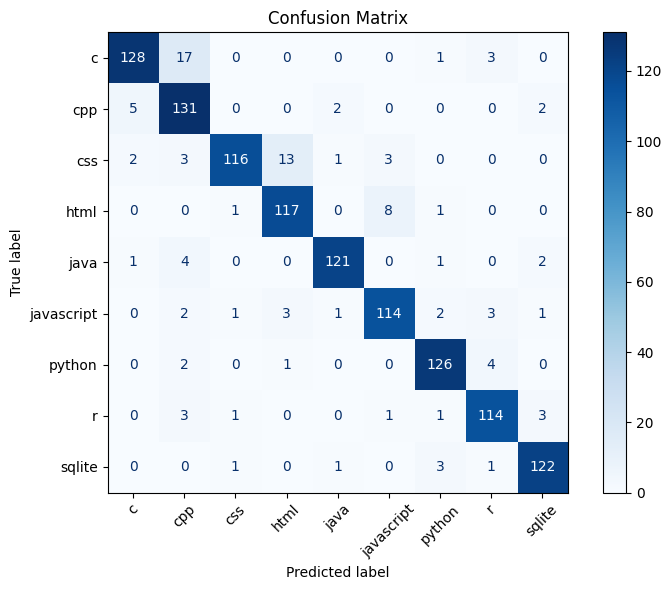

In [193]:
val_loss, val_acc = evaluate(model_v5, val_loader, show_confusion_matrix=True, class_names=['c','cpp','css','html','java','javascript','python','r','sqlite'])

## Validation Accuracy Across Models

An overview of how each model performed during validation:

* **Version 1 & 2** *(Embedding-only & Embedding + Positional Encoding)*:
    * These models **fail to capture structural patterns** in code.
    * Accuracy remains low — they are **not suitable** for code snippet classification.


* **Version 3** *(Single Attention Layer)*:
    * **Best performing model overall**, despite its simplicity.
    * Achieves **highest accuracy** among all versions.
    * Strikes an excellent balance between performance and implementation complexity.
* **Version 4 & 5** *(Multi-head Attention + FFN + LayerNorm)*:
    * Show a **steeper accuracy increase during early epochs**.
    * However, they **do not outperform** V3 significantly in final accuracy.
    * Higher model complexity may not be justified for this task without further tuning.

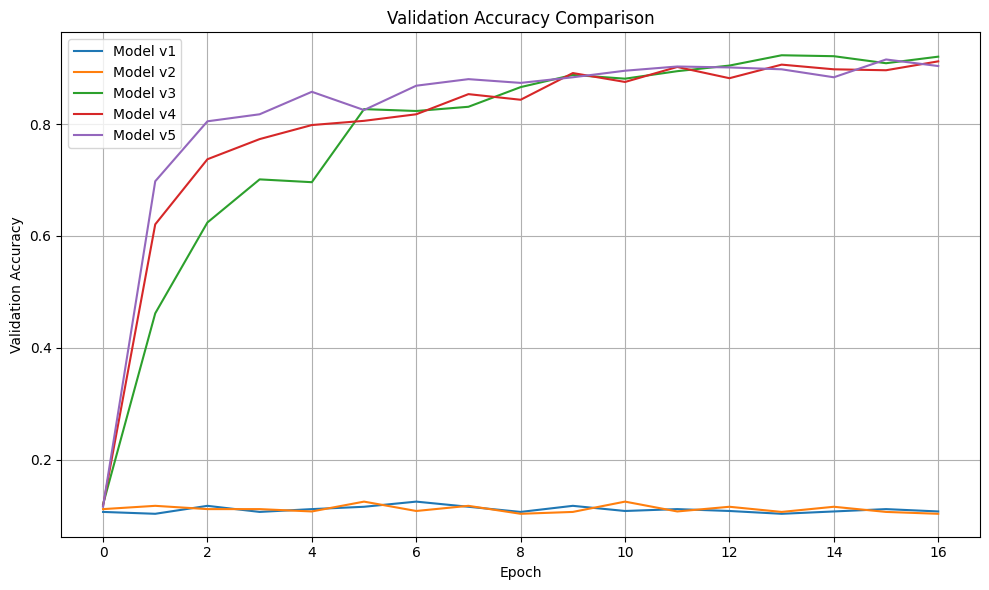

In [194]:
models_stats = {
    'v1': stats_v1,
    'v2': stats_v2,
    'v3': stats_v3,
    'v4': stats_v4,
    'v5': stats_v5,
}

plt.figure(figsize=(10, 6))

for version, stats in models_stats.items():
    val_accuracies = stats[3]
    plt.plot(val_accuracies, label=f'Model {version}')

plt.title('Validation Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Train vs Validation Loss

This section helps determine whether models are **underfitting** or **overfitting** based on their training and validation loss curves.

- **Version 1**:
    - Shows **minimal training progress**

- **Version 2**:
    - Slight improvement in **training loss**, but **validation loss remains flat**.
    - Still suggests **underfitting**, though embeddings are starting to capture some structure.

- **Version 3**:
    -  Displays a **more typical learning curve**.
    - Validation loss follows training loss, though with occasional **sharp spikes** — likely caused by **difficult batches** (e.g., ambiguous C/C++ or HTML/JS snippets).

- **Version 4 & 5**:
  - Similar trend to V3, with **larger and more frequent spikes**.
  - This could be due to the models' increased capacity, reacting more sensitively to noise or hard-to-classify samples.


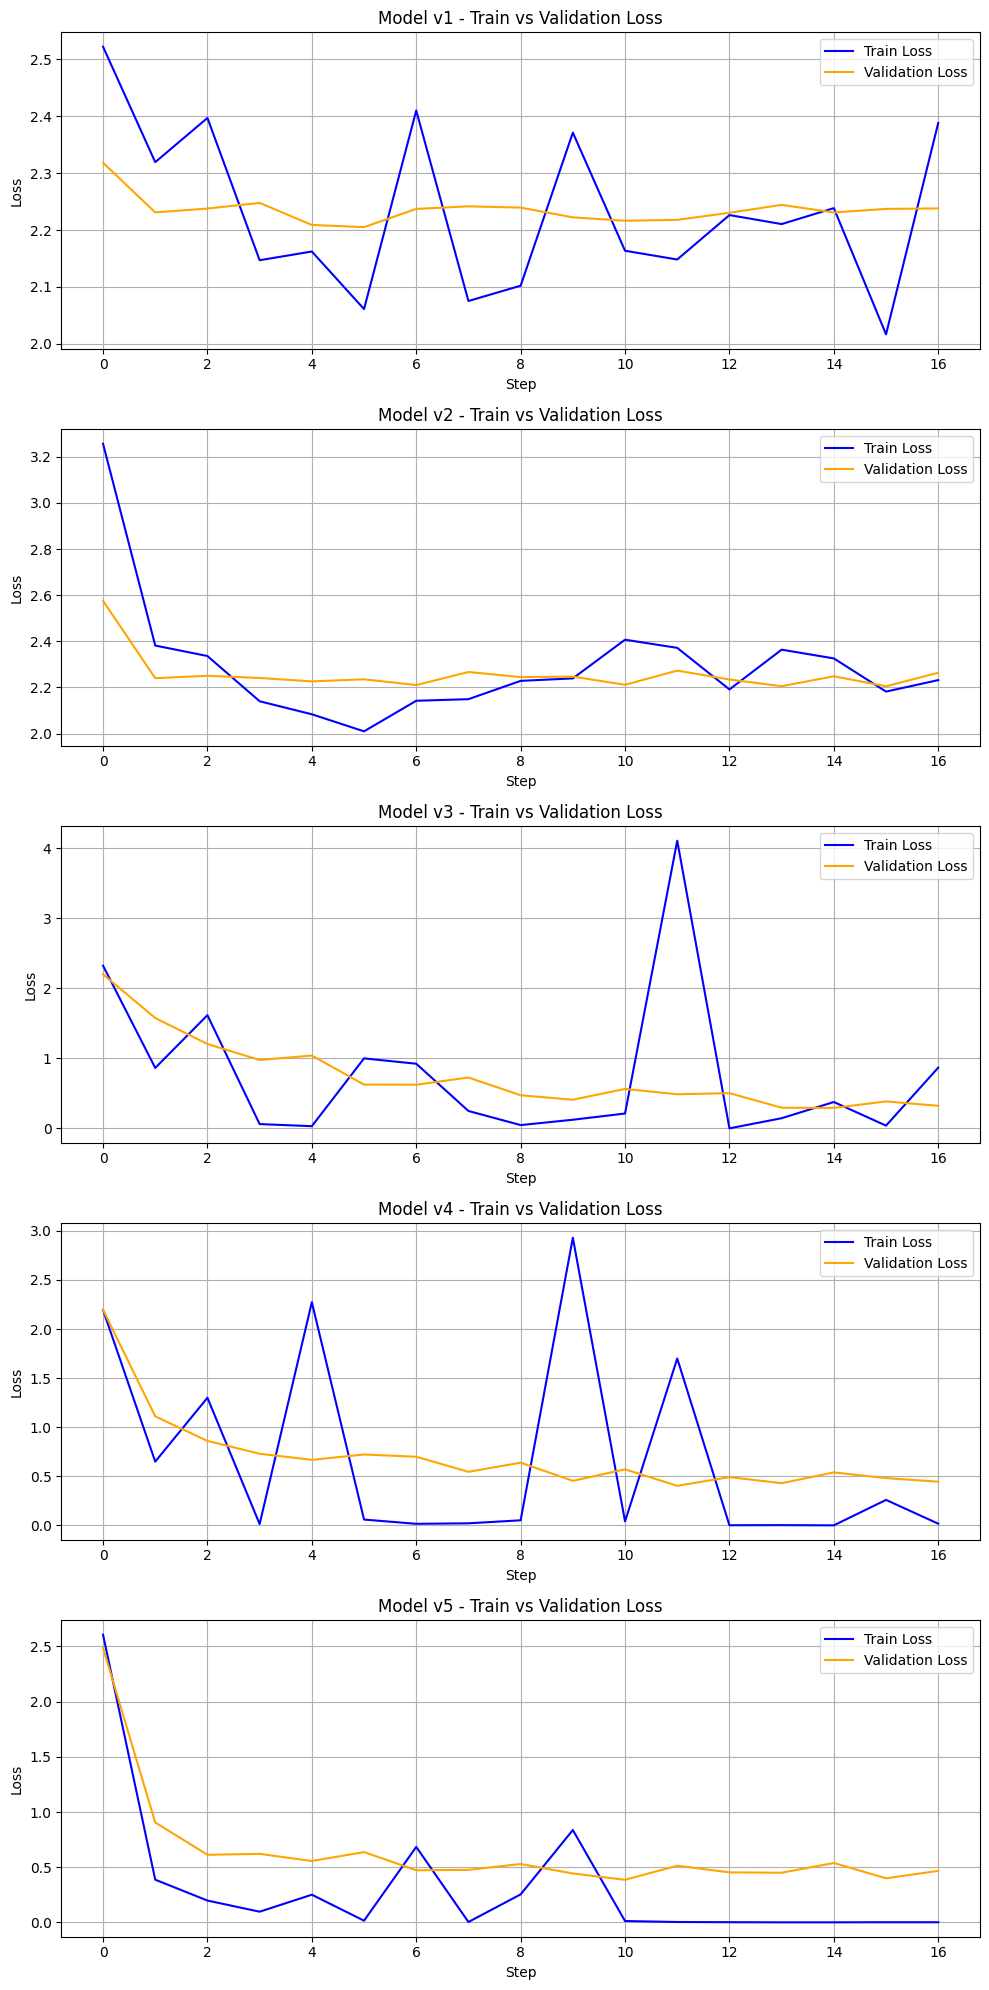

In [195]:
num_models = len(models_stats)
fig, axes = plt.subplots(num_models, 1, figsize=(10, 4 * num_models), sharex=False)

for ax, (version, stats) in zip(axes, models_stats.items()):
    train_losses = stats[0]
    val_losses = stats[2]

    ax.plot(train_losses, label='Train Loss', color='blue')
    ax.plot(val_losses, label='Validation Loss', color='orange')
    ax.set_title(f'Model {version} - Train vs Validation Loss')
    ax.set_xlabel('Step')
    ax.set_ylabel('Loss')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

## Gradient Norms During Training

Monitoring gradient norms helps detect issues like **vanishing** or **exploding gradients**, which can hinder training stability and convergence.

- **Version 1 & 2**:
  - Gradients show some **long-run stabilization**, but remain inconsistent.
  - Indicate **training instability** and lack of sufficient learning capacity.

- **Version 3, 4 & 5**:
  - Some signs of **gradient vanishing** over long epochs.
  - However, even with:
    - **Residual connections**
    - **Layer normalization**
    - **Dropout regularization**

    ...in **Version 5**, gradient behavior remains **suboptimal**.
  - Suggests that additional techniques (e.g. learning rate warm-up) I could not manage to find the core problem in gradient exploding or vanishing in some cases :(.

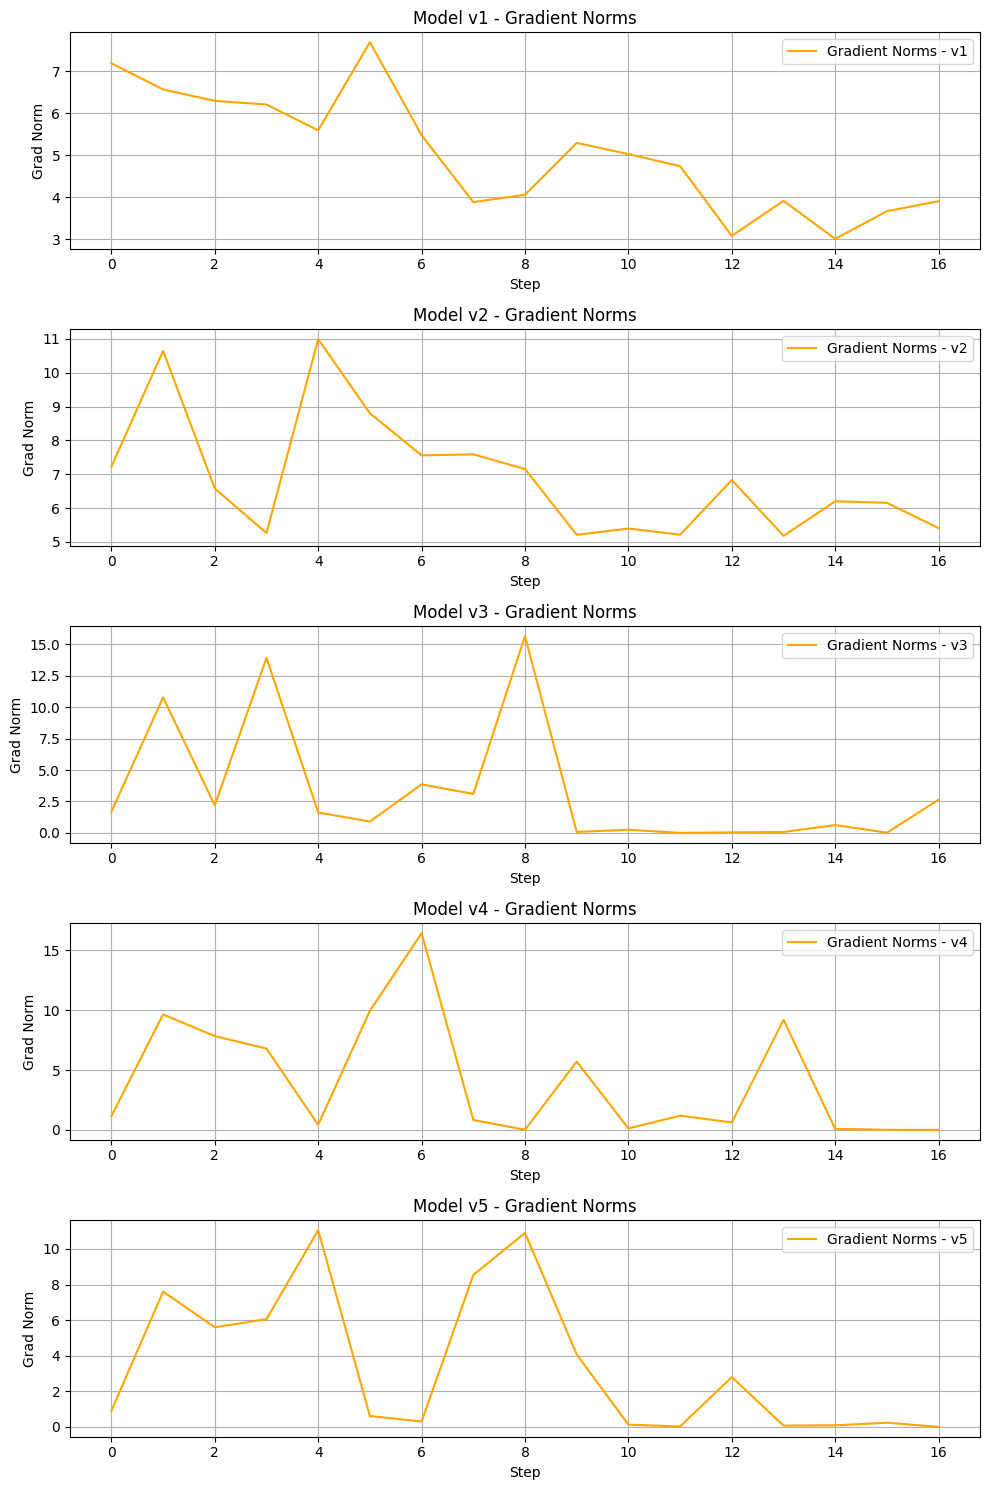

In [153]:
fig, axes = plt.subplots(num_models, 1, figsize=(10, 3 * num_models), sharex=False)

for i, (version, stats) in enumerate(models_stats.items()):
    grad_norms = stats[1] 
    
    axes[i].plot(grad_norms, label=f'Gradient Norms - {version}', color='orange')
    axes[i].set_title(f'Model {version} - Gradient Norms')
    axes[i].set_xlabel('Step')
    axes[i].set_ylabel('Grad Norm')
    axes[i].legend()
    axes[i].grid(True)

plt.tight_layout()
plt.show()


## Throughput Analysis

Evaluating **model throughput** helps balance performance with computational efficiency.

- **Version 1** (Embedding-only):
  - Achieves the **highest throughput**, as expected.
  - Minimal computation and model size.

- Throughput **decreases progressively** from V2 to V5:
  - Each additional component — positional encoding, attention layers, multi-head mechanisms, feed-forward networks — increases computational load.
  
-  **V3–V5** models, especially with attention, suffer from lower throughput.
  - Training was performed on **CPU**, so fast attention mechanisms (e.g., FlashAttention) could **not** be used to accelerate performance.

---

### Tradeoff Summary

When comparing both **validation accuracy** and **throughput**:

- **Version 3 (single attention layer)** offers the **best trade-off**:
  - High accuracy
  - Simpler architecture
  - Reasonable throughput even on CPU

**Conclusion**: For practical CPU-based training setups, **Model V3** stands out as the most effective and efficient choice.

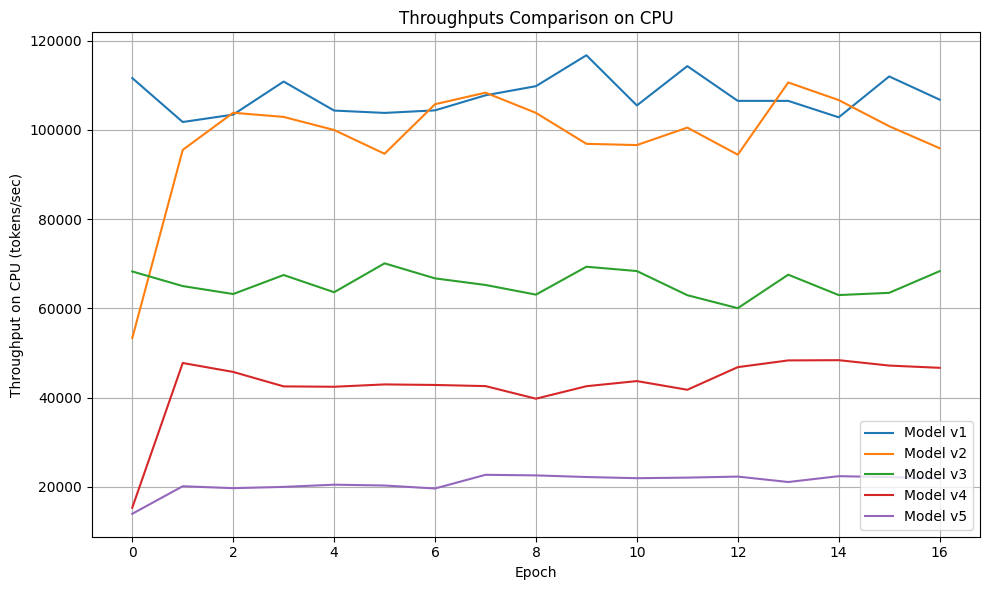

In [200]:
plt.figure(figsize=(10, 6))

for version, stats in models_stats.items():
    troughputs = stats[4]
    plt.plot(troughputs, label=f'Model {version}')

plt.title('Throughputs Comparison on CPU')
plt.xlabel('Epoch')
plt.ylabel('Throughput on CPU (tokens/sec)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()